In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')
print(os.getcwd())

Mounted at /content/drive/
/content


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.core import Flatten
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
# from keras.utils import to_categorical
from sklearn import preprocessing
from keras.utils.vis_utils import plot_model
from keras import initializers

import pandas as pd
import numpy as np
import re
import spacy
from spacy import displacy
from spacy.lemmatizer import Lemmatizer
from collections import Counter
import pandas as pd
import numpy as np
import time
import timeit

import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
event_data = pd.read_csv('drive/MyDrive/Colab Notebooks/event_timeline_generation/CWMG_action_tag.csv')

sentence_list = event_data.sentence.tolist()
cluster_list = event_data.cluster.tolist()
tag_list = event_data.keywords.tolist()
date_list = event_data['publication date'].tolist()
action_list = event_data.action.tolist()
id_list = event_data.index.tolist()

pair_dict = {'id1': [], 'id2': [], 'sentence1': [], 'sentence2': [], 'date1': [], 'date2': [], 'action1': [], 'action2': [],'tag1': [], 'tag2': [],  'similarity': []}

for i in range(len(sentence_list)):
    for j in range(len(sentence_list)):
        pair_dict['id1'].append(id_list[i])
        pair_dict['id2'].append(id_list[j])
        pair_dict['sentence1'].append(sentence_list[i])
        pair_dict['sentence2'].append(sentence_list[j])
        pair_dict['tag1'].append(tag_list[i])
        pair_dict['tag2'].append(tag_list[j])
        pair_dict['action1'].append(action_list[i])
        pair_dict['action2'].append(action_list[j])
        pair_dict['date1'].append(date_list[i])
        pair_dict['date2'].append(date_list[j])
        if cluster_list[i] == cluster_list[j]:
            pair_dict['similarity'].append(1)
        else:
            pair_dict['similarity'].append(0)
df = pd.DataFrame.from_dict(pair_dict)


df.action1 = df.action1.fillna("")
df.action2 = df.action2.fillna("")
df.tag1 = df.tag1.fillna("")
df.tag2 = df.tag2.fillna("")
df.head()


,id1,id2,sentence1,sentence2,date1,date2,action1,action2,tag1,tag2,similarity
0,0,0,The public have been told that Dharasana is pr...,The public have been told that Dharasana is pr...,"1930, May 4","1930, May 4",'tell','tell',"Dharasana Satyagraha, salt march, Dharasana","Dharasana Satyagraha, salt march, Dharasana",1
1,0,1,The public have been told that Dharasana is pr...,It is as effectively under Government control ...,"1930, May 4","1930, May 4",'tell',,"Dharasana Satyagraha, salt march, Dharasana","Dharasana, Lord Irwin",1
2,0,2,The public have been told that Dharasana is pr...,Not a pinch of salt can be removed without the...,"1930, May 4","1930, May 4",'tell','remove',"Dharasana Satyagraha, salt march, Dharasana","Lord Irwin, Dandi March, Dharasana",1
3,0,3,The public have been told that Dharasana is pr...,He was arrested at 12.45 a.m. on May 5.,"1930, May 4","1930, May 4",'tell','arrest',"Dharasana Satyagraha, salt march, Dharasana","arrest, salt satyagraha, imprisonment of Mahat...",0
4,0,4,The public have been told that Dharasana is pr...,"Instead, whilst the known leaders have been de...","1930, May 4","1930, May 4",'tell','deal',"Dharasana Satyagraha, salt march, Dharasana","assault, nonviolent resistance, freedom struggle",0


In [ ]:
from sklearn.model_selection import train_test_split

# df = df.sample(frac=0.5)
X_train, X_test, y_train, y_test = train_test_split(df[['id1', 'id2', 'sentence1', 'sentence2', 'action1', 'action2', 'date1', 'date2', 'tag1', 'tag2']], df.similarity, test_size=0.3, random_state=1000)

In [ ]:
from sklearn.preprocessing import MinMaxScaler


tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(train_df.cleaned_text)
# X_train  = tokenizer.texts_to_sequences(train_df.cleaned_text)
# X_test  = tokenizer.texts_to_sequences(test_df.cleaned_text)
tokenizer.fit_on_texts(X_train.sentence1 + X_train.sentence2)
sentences_train = X_train
X_train1 = tokenizer.texts_to_sequences(X_train.sentence1)
X_train2 = tokenizer.texts_to_sequences(X_train.sentence2)
X_train3 = tokenizer.texts_to_sequences(X_train.date1)
X_train4 = tokenizer.texts_to_sequences(X_train.date2)
X_train5 = tokenizer.texts_to_sequences(X_train.tag1)
X_train6 = tokenizer.texts_to_sequences(X_train.tag2)
X_train7 = tokenizer.texts_to_sequences(X_train.action1)
X_train8 = tokenizer.texts_to_sequences(X_train.action2)

X_test1 = tokenizer.texts_to_sequences(X_test.sentence1)
X_test2 = tokenizer.texts_to_sequences(X_test.sentence2)
X_test3 = tokenizer.texts_to_sequences(X_test.date1)
X_test4 = tokenizer.texts_to_sequences(X_test.date2)
X_test5 = tokenizer.texts_to_sequences(X_test.tag1)
X_test6 = tokenizer.texts_to_sequences(X_test.tag2)
X_test7 = tokenizer.texts_to_sequences(X_test.action1)
X_test8 = tokenizer.texts_to_sequences(X_test.action2)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen_sent = 64
maxlen_other = 10
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen_sent)
X_train2 = pad_sequences(X_train2, padding='post', maxlen=maxlen_sent)
X_train3 = pad_sequences(X_train3, padding='post', maxlen=maxlen_other)
X_train4 = pad_sequences(X_train4, padding='post', maxlen=maxlen_other)
X_train5 = pad_sequences(X_train5, padding='post', maxlen=maxlen_other)
X_train6 = pad_sequences(X_train6, padding='post', maxlen=maxlen_other)
X_train7 = pad_sequences(X_train7, padding='post', maxlen=maxlen_other)
X_train8 = pad_sequences(X_train8, padding='post', maxlen=maxlen_other)

X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen_sent)
X_test2 = pad_sequences(X_test2, padding='post', maxlen=maxlen_sent)
X_test3 = pad_sequences(X_test3, padding='post', maxlen=maxlen_other)
X_test4 = pad_sequences(X_test4, padding='post', maxlen=maxlen_other)
X_test5 = pad_sequences(X_test5, padding='post', maxlen=maxlen_other)
X_test6 = pad_sequences(X_test6, padding='post', maxlen=maxlen_other)
X_test7 = pad_sequences(X_test7, padding='post', maxlen=maxlen_other)
X_test8 = pad_sequences(X_test8, padding='post', maxlen=maxlen_other)



# prepare tokenizer
t = Tokenizer()
docs = X_train.sentence1 + X_train.sentence2 + X_train.date1 + X_train.date2 + X_train.tag1 + X_train.tag2 + X_train.action1 + X_train.action2
# docs = X_train.sentence1

t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

# pad documents to a max length of 64 words
maxlen = 64
padded_docs = pad_sequences(encoded_docs, maxlen=maxlen, padding='post')
print(padded_docs)
# load the whole embedding into memory
embeddings_index = dict()
f = open('drive/MyDrive/Colab Notebooks/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

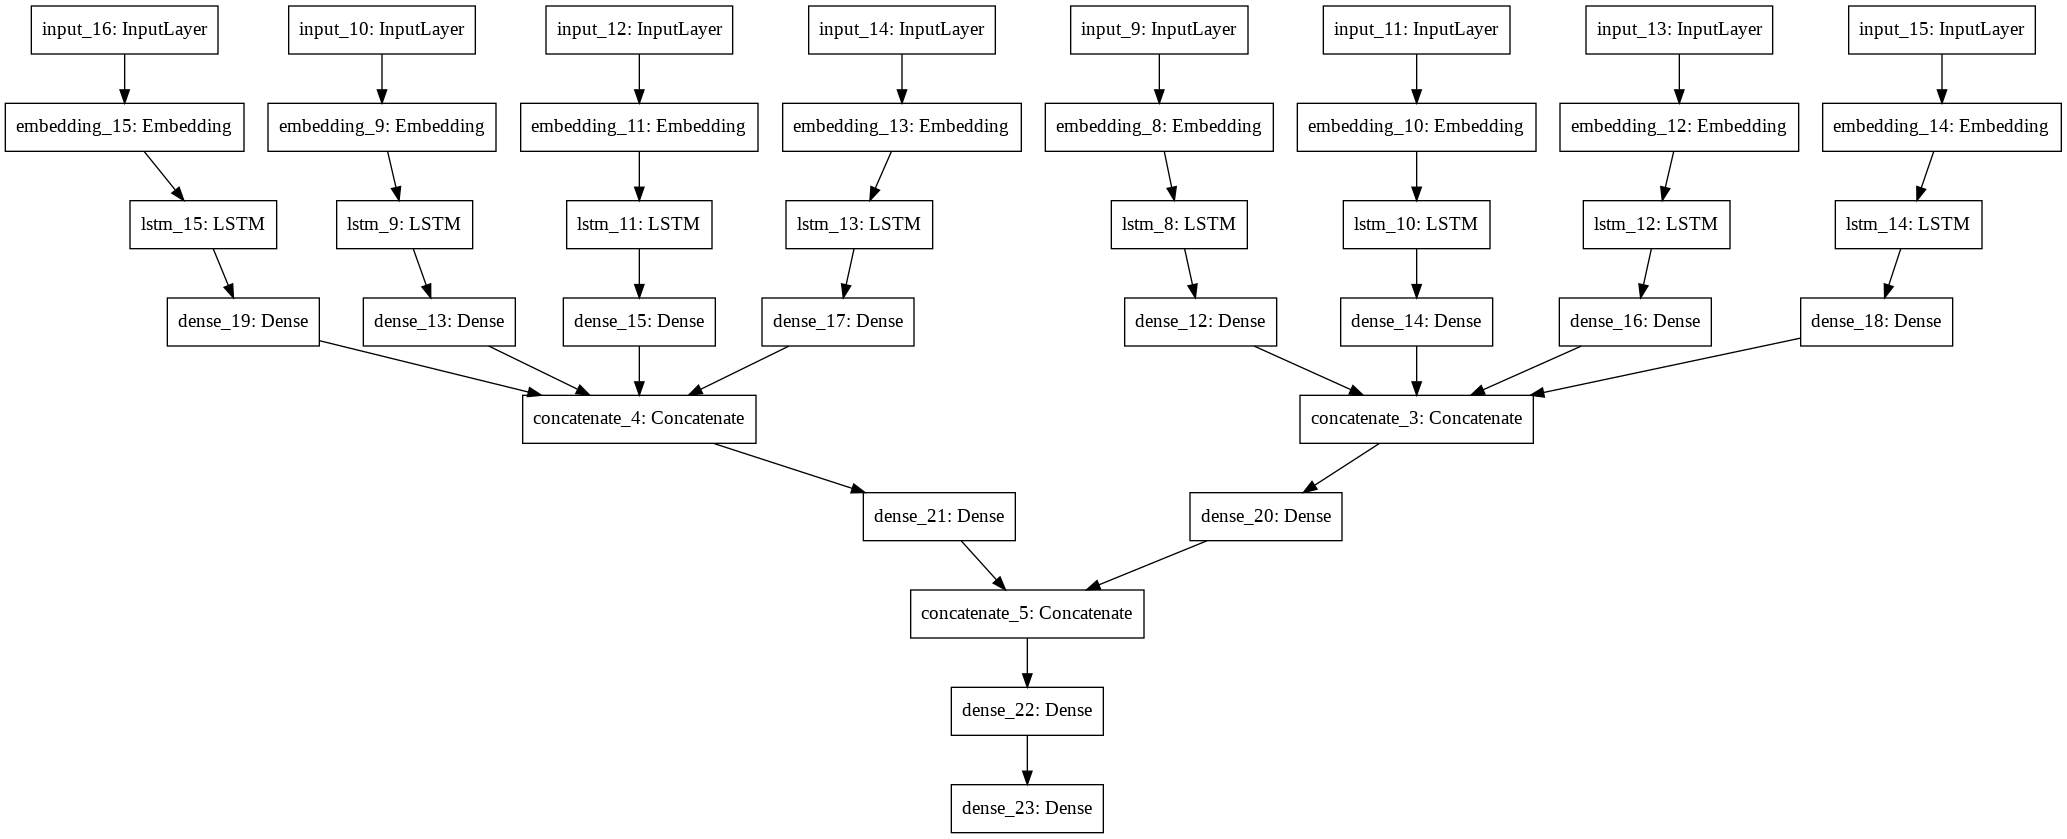

In [ ]:
input_1 = Input(shape=(64,))
input_2 = Input(shape=(64,))

input_3 = Input(shape=(maxlen_other,))
input_4 = Input(shape=(maxlen_other,))

input_5 = Input(shape=(maxlen_other,))
input_6 = Input(shape=(maxlen_other,))

input_7 = Input(shape=(maxlen_other,))
input_8 = Input(shape=(maxlen_other,))


embedding_layer1 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
embedding_layer2 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_2)
embedding_layer3 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_3)
embedding_layer4 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_4)
embedding_layer5 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_5)
embedding_layer6 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_6)
embedding_layer7 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_7)
embedding_layer8 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_8)

LSTM_Layer_1 = LSTM(128)(embedding_layer1)
LSTM_Layer_2 = LSTM(128)(embedding_layer2)
LSTM_Layer_3 = LSTM(128)(embedding_layer3)
LSTM_Layer_4 = LSTM(128)(embedding_layer4)
LSTM_Layer_5 = LSTM(128)(embedding_layer5)
LSTM_Layer_6 = LSTM(128)(embedding_layer6)
LSTM_Layer_7 = LSTM(128)(embedding_layer7)
LSTM_Layer_8 = LSTM(128)(embedding_layer8)


dense_layer_1 = Dense(64, activation='relu')(LSTM_Layer_1)
dense_layer_2 = Dense(64, activation='relu')(LSTM_Layer_2)
dense_layer_3 = Dense(32, activation='relu')(LSTM_Layer_3)
dense_layer_4 = Dense(32, activation='relu')(LSTM_Layer_4)
dense_layer_5 = Dense(32, activation='relu')(LSTM_Layer_5)
dense_layer_6 = Dense(32, activation='relu')(LSTM_Layer_6)
dense_layer_7 = Dense(32, activation='relu')(LSTM_Layer_7)
dense_layer_8 = Dense(32, activation='relu')(LSTM_Layer_8)

concat_layer1 = Concatenate()([dense_layer_1, dense_layer_3, dense_layer_5, dense_layer_7])
dense_layer_5 = Dense(32, activation='relu')(concat_layer1)
concat_layer2 = Concatenate()([dense_layer_2, dense_layer_4, dense_layer_6, dense_layer_8])
dense_layer_6 = Dense(32, activation='relu')(concat_layer2)

concat_layer = Concatenate()([dense_layer_5, dense_layer_6])

dense_layer_7 = Dense(64, activation='relu')(concat_layer)
# dense_layer_8 = Dropout(0.3)(dense_layer_7)
output = Dense(1, activation='sigmoid')(dense_layer_7)
model1 = Model(inputs=[input_1, input_2, input_3, input_4, input_5, input_6, input_7, input_8], outputs=output)
# model = Model(inputs=[input_1, input_2], outputs=output)

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

plot_model(model1, to_file='model_plot2.png',  show_layer_names=True)


In [ ]:
from sklearn.utils import compute_class_weight

w = compute_class_weight('balanced', np.unique(y_train), y_train)

# here I am adding only two categories with their corresponding weights
# you can spin a loop or continue by hand until you include all of your categories
weight = {
     np.unique(y_train)[0] : w[0], # class 0 with weight 0
     np.unique(y_train)[1] : w[1]  # class 1 with weight 1 
}

# checkpoint = keras.callbacks.ModelCheckpoint('drive/MyDrive/Colab Notebooks/saved_models/model_covid_{epoch:08d}.h5', period=20) 
history = model1.fit([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6, X_train7, X_train8], y_train,
                    epochs=20,
                    verbose=True,
                    batch_size=32,
                    class_weight = weight)
                    # callbacks = [checkpoint] )





Epoch 1/20
194/194 [==============================] - 39s 142ms/step - loss: 0.5424 - acc: 0.7285
Epoch 2/20
194/194 [==============================] - 28s 142ms/step - loss: 0.4486 - acc: 0.7264
Epoch 3/20
194/194 [==============================] - 28s 142ms/step - loss: 0.4308 - acc: 0.7403
Epoch 4/20
194/194 [==============================] - 28s 143ms/step - loss: 0.3577 - acc: 0.7445
Epoch 5/20
194/194 [==============================] - 28s 143ms/step - loss: 0.3552 - acc: 0.7083
Epoch 6/20
194/194 [==============================] - 27s 141ms/step - loss: 0.3513 - acc: 0.6907
Epoch 7/20
194/194 [==============================] - 27s 142ms/step - loss: 0.3503 - acc: 0.7069
Epoch 8/20
194/194 [==============================] - 27s 141ms/step - loss: 0.3289 - acc: 0.7316
Epoch 9/20
194/194 [==============================] - 27s 141ms/step - loss: 0.3306 - acc: 0.7454
Epoch 10/20
194/194 [==============================] - 27s 141ms/step - loss: 0.5055 - acc: 0.7082
Epoch 11/20
194/194

In [ ]:
# model1 = keras.models.load_model('drive/MyDrive/Colab Notebooks/saved_models/model_covid_00000080.h5')
preds = model1.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6,  X_test7, X_test8])
# preds = [1 if p > 0.3 else 0 for p in preds]
# preds

In [ ]:
preds1 = [1 if p > 0.5 else 0 for p in preds]
preds1

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90      2478
           1       0.26      0.96      0.41       173

    accuracy                           0.82      2651
   macro avg       0.63      0.89      0.65      2651
weighted avg       0.95      0.82      0.86      2651



In [ ]:
event_len = len(event_data.sentence.tolist())
data_res = np.zeros((event_len, event_len), dtype=int)
data_key = np.zeros((event_len, event_len), dtype=int)

cluster_mat_res = []
cluster_mat_key = []
num = 0
for i, j, sim in zip(X_test.id1, X_test.id2, preds1):
    if sim == 1 and i !=j :
        cluster_mat_res.append([i, j])
        data_res[i][j] = 1
    # cluster_mat_res.append([i, j, sim])
    # data_res[i][j] = sim
for i, j, sim in zip(X_test.id1, X_test.id2, y_test):
    if i != j :
        cluster_mat_key.append([i, j])
        data_key[i][j] = sim




In [ ]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering

res_cluster = AgglomerativeClustering(affinity='precomputed', n_clusters=28, linkage='complete').fit(data_res)
key_cluster = AgglomerativeClustering(affinity='precomputed', n_clusters=28, linkage='complete').fit(data_key)

In [ ]:
key_identifier = list(range(0, len(key_cluster.labels_)))
res_identifier = list(range(0, len(res_cluster.labels_)))
key_labels = key_cluster.labels_
res_labels = res_cluster.labels_


cdict = {}
ldict = {}
key = []
response = []
# identifier = event_file.id.tolist()
# identifier
for i, lab in zip(res_identifier, res_labels):
    try:
        cdict[lab].add(i)
    except:
        cdict[lab] = {i}
for k, v in cdict.items():
    response.append(v)


for i, lab in zip(key_identifier, key_labels):
    try:
        ldict[lab].add(i)
    except:
        ldict[lab] = {i}
#     key.append(set(x))
ldict

for k, v in ldict.items():
    key.append(v)

In [ ]:
print(muc(key, response))
print(b_cubed(key, response))
print(ceaf_e(key, response))
print(blanc(key, response))

(0.9242424242424242, 0.9242424242424242, 0.9242424242424242)
(0.9019641705811919, 0.45390070921985815, 0.6038981948964958)
(0.8424807742648822, 0.8424807742648822, 0.8424807742648822)
(0.7116153521799484, 0.5950151313653832, 0.5343739737828066)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# from sentence_transformers import SentenceTransformer
from sklearn.metrics import cohen_kappa_score

import math
import typing as ty

from statistics import mean, harmonic_mean

import numpy as np

from scipy.optimize import linear_sum_assignment

def trace(cluster: ty.Set, partition: ty.Iterable[ty.Set]) -> ty.Iterable[ty.Set]:
    remaining = set(cluster)
    for a in partition:
        common = remaining.intersection(a)
        if common:
            remaining.difference_update(common)
            yield common
    for x in sorted(remaining):
        yield set((x,))
        
class RemapClusteringsReturn(ty.NamedTuple):
    clusterings: ty.Sequence[ty.Sequence[ty.Sequence[int]]]
    elts_map: ty.Dict[ty.Hashable, int]


def remap_clusterings(
    clusterings: ty.Sequence[ty.Sequence[ty.Set[ty.Hashable]]],
) -> RemapClusteringsReturn:
    """Remap clusterings of arbitrary elements to clusterings of integers."""
    elts = set(e for clusters in clusterings for c in clusters for e in c)
    elts_map = {e: i for i, e in enumerate(elts)}
    res = []
    for clusters in clusterings:
        remapped_clusters = []
        for c in clusters:
            remapped_c = [elts_map[e] for e in c]
            remapped_clusters.append(remapped_c)
        res.append(remapped_clusters)
    return RemapClusteringsReturn(res, elts_map)

def muc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[float, float, float]:

    # Edge case
    if all(len(k) == 1 for k in key) or all(len(r) == 1 for r in response):
        return 0.0, 0.0, 0.0
    R = sum(len(k) - sum(1 for _ in trace(k, response)) for k in key) / sum(
        len(k) - 1 for k in key
    )
    P = sum(len(r) - sum(1 for _ in trace(r, key)) for r in response) / sum(
        len(r) - 1 for r in response
    )
    F = harmonic_mean((R, P))
    return R, P, F

def b_cubed(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[float, float, float]:
    if sum(len(k) for k in key) == 0:
        R = 0.0
    else:
        R = math.fsum(
            len(k.intersection(r)) ** 2 / len(k) for k in key for r in response
        ) / sum(len(k) for k in key)
    if sum(len(r) for r in response) == 0:
        P = 0.0
    else:
        P = math.fsum(
            len(r.intersection(k)) ** 2 / len(r) for r in response for k in key
        ) / sum(len(r) for r in response)
    F = harmonic_mean((R, P))
    return R, P, F

def ceaf(
    key: ty.Sequence[ty.Set],
    response: ty.Sequence[ty.Set],
    score: ty.Callable[[ty.Set, ty.Set], float],
) -> ty.Tuple[float, float, float]:
    if len(response) == 0 or len(key) == 0:
        return 0.0, 0.0, 0.0
    else:
        cost_matrix = np.array([[-score(k, r) for r in response] for k in key])
        # TODO: See https://github.com/allenai/allennlp/issues/2946 for ideas on speeding
        # the next line up
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total_score = -cost_matrix[row_ind, col_ind].sum()
        R = total_score / math.fsum(score(k, k) for k in key)
        P = total_score / math.fsum(score(r, r) for r in response)
        F = harmonic_mean((R, P))
        return R, P, F
def ceaf_e(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[float, float, float]:

    def Φ_4(k, r):
        return 2 * len(k.intersection(r)) / (len(k) + len(r))

    return ceaf(key, response, Φ_4)

def blanc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set], fast=True,
) -> ty.Tuple[float, float, float]:
    r"""
    Return the BLANC `$(R, P, F)$` scores for a `#response` clustering given a `#key` clustering.
    ## Notes
      - Mention identifiers have to be comparable
      - To ensure the compliance with the reference implementation, the edge cases results are
        those from Recasens and Hovy (2011) rather than from the more recent Luo et al. (2014) when
        those two disagree. This has an effect for the N-6 testcase, where according to Luo et al.
        (2014), BLANC should be `$\frac{0+F_n}{2}$` since `$C_k=∅$` and `$C_r≠∅$`, but according to
        Recasens and Hovy (2011), BLANC should be `$F_n$`.
    """
    if fast:
        C_score, N_score = fast_detailed_blanc(key, response)
    else:
        C_score, N_score = detailed_blanc(key, response)
    if C_score is None:
        assert N_score is not None  # nosec:B101
        return N_score
    if N_score is None:
        assert C_score is not None  # nosec:B101
        return C_score
    return ty.cast(
        ty.Tuple[float, float, float],
        tuple(np.mean((C_score, N_score), axis=0).tolist()),
    )


def links_from_clusters(
    clusters: ty.Iterable[ty.Set],
) -> ty.Tuple[
    ty.Set[ty.Tuple[ty.Hashable, ty.Hashable]],
    ty.Set[ty.Tuple[ty.Hashable, ty.Hashable]],
]:
    r"""
    Return a `(coreference_links, non-coreference_links)` tuple corresponding to a clustering.
    The links are given as sorted couples for uniqueness
    """
    clusters_lst = [list(c) for c in clusters]
    C = set()
    N = set()
    for i, c in enumerate(clusters_lst[:-1]):
        for j, e in enumerate(c[:-1]):
            # Since the links are symmetric, we only add the links between `e` and
            # the following mentions
            for f in c[j + 1 :]:
                C.add((e, f) if e <= f else (f, e))
        for other in clusters_lst[i + 1 :]:
            for e in c:
                for f in other:
                    N.add((e, f) if e <= f else (f, e))
    #  We missed the coreference links for the last cluster, add them here
    last_cluster = clusters_lst[-1]
    for j, e in enumerate(last_cluster):
        for f in last_cluster[j + 1 :]:
            C.add((e, f) if e <= f else (f, e))
    return C, N


def detailed_blanc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[
    ty.Union[ty.Tuple[float, float, float], None],
    ty.Union[ty.Tuple[float, float, float], None],
]:
    """Return BLANC `$(R, P, F)$` scores for coreference and non-coreference respectively."""

    # Edge case : a single mention in both `key` and `response` clusters
    # in that case, `C_k`, `C_r`, `N_k` and `N_r` are all empty, so we need a separate examination
    # of the mentions to know if we are very good or very bad.
    if len(key) == len(response) == 1 and len(key[0]) == len(response[0]) == 1:
        if key[0] == response[0]:
            return ((1.0, 1.0, 1.0), (1.0, 1.0, 1.0))
        else:
            return ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))

    C_k, N_k = links_from_clusters(key)
    C_r, N_r = links_from_clusters(response)

    tp_c = len(C_k.intersection(C_r))
    tp_n = len(N_k.intersection(N_r))
    c_k, n_k = len(C_k), len(N_k)
    c_r, n_r = len(C_r), len(N_r)

    if not c_k and not c_r:
        R_c, P_c, F_c = (1.0, 1.0, 1.0)
    elif not c_k or not c_r:
        R_c, P_c, F_c = (0.0, 0.0, 0.0)
    else:
        R_c, P_c = tp_c / c_k, tp_c / c_r
        F_c = 2 * tp_c / (c_k + c_r)

    if not n_k and not n_r:
        R_n, P_n, F_n = (1.0, 1.0, 1.0)
    elif not n_k or not n_r:
        R_n, P_n, F_n = (0.0, 0.0, 0.0)
    else:
        R_n, P_n = tp_n / n_k, tp_n / n_r
        F_n = 2 * tp_n / (n_k + n_r)

    # Edge cases
    if not c_k:
        return (None, (R_n, P_n, F_n))
    if not n_k:
        return ((R_c, P_c, F_c), None)

    return ((R_c, P_c, F_c), (R_n, P_n, F_n))


class AdjacencyReturn(ty.NamedTuple):
    """Represents a clustering of integers as an adjacency matrix and a presence mask"""

    adjacency: np.ndarray
    presence: np.ndarray


def adjacency(clusters: ty.List[ty.List[int]], num_elts: int) -> AdjacencyReturn:
    adjacency = np.zeros((num_elts, num_elts), dtype=np.bool)
    presence = np.zeros(num_elts, dtype=np.bool)
    # **Note** The nested loop makes the complexity of this `$∑|c|²$` but we are only doing memory
    # access, which is really fast, so this is not really an issue. In comparison, doing it by
    # computing the Gram matrix one-hot elt-cluster attribution matrix was making `fast_blanc` 3×
    # slower than the naïve version.
    for c in clusters:
        # Note: don't be clever and use numpy array indicing here, see
        # <https://docs.scipy.org/doc/numpy/user/basics.indexing.html?highlight=slice#assigning-values-to-indexed-arrays>
        # for why it would be slower. If you want to get C loops here, cythonize it instead (nut
        # it's probably not worth it)
        for e in c:
            presence[e] = True
            for f in c:
                if f != e:
                    adjacency[e, f] = True
    return AdjacencyReturn(adjacency, presence)


def fast_detailed_blanc(
    key: ty.Sequence[ty.Set], response: ty.Sequence[ty.Set]
) -> ty.Tuple[
    ty.Union[ty.Tuple[float, float, float], None],
    ty.Union[ty.Tuple[float, float, float], None],
]:
    """Return BLANC `$(R, P, F)$` scores for coreference and non-coreference respectively."""

    # Edge case : a single mention in both `key` and `response` clusters
    # in that case, `C_k`, `C_r`, `N_k` and `N_r` are all empty, so we need a separate examination
    # of the mentions to know if we are very good or very bad.
    if len(key) == len(response) == 1 and len(key[0]) == len(response[0]) == 1:
        if key[0] == response[0]:
            return ((1.0, 1.0, 1.0), (1.0, 1.0, 1.0))
        else:
            return ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))

    (key, response), mentions_map = remap_clusterings([key, response])
    num_mentions = len(mentions_map)

    key_coref_links, key_presence = adjacency(key, num_mentions)
    response_coref_links, response_presence = adjacency(response, num_mentions)

    tp_c = np.logical_and(key_coref_links, response_coref_links).sum() // 2
    c_k = key_coref_links.sum() // 2
    c_r = response_coref_links.sum() // 2

    # Headache ahead
    common_links = np.logical_and(
        np.outer(key_presence, key_presence),
        np.outer(response_presence, response_presence),
    )
    # There is no link between a mention and itself
    np.fill_diagonal(common_links, False)
    tp_n = (
        np.logical_and(
            common_links,
            np.logical_not(np.logical_or(key_coref_links, response_coref_links)),
        ).sum()
        / 2
    )
    num_key_mentions = key_presence.sum()
    n_k = (num_key_mentions * (num_key_mentions - 1)) // 2 - c_k
    num_response_mentions = response_presence.sum()
    n_r = (num_response_mentions * (num_response_mentions - 1)) // 2 - c_r

    if not c_k and not c_r:
        R_c, P_c, F_c = (1.0, 1.0, 1.0)
    elif not c_k or not c_r:
        R_c, P_c, F_c = (0.0, 0.0, 0.0)
    else:
        R_c, P_c = tp_c / c_k, tp_c / c_r
        F_c = 2 * tp_c / (c_k + c_r)

    if not n_k and not n_r:
        R_n, P_n, F_n = (1.0, 1.0, 1.0)
    elif not n_k or not n_r:
        R_n, P_n, F_n = (0.0, 0.0, 0.0)
    else:
        R_n, P_n = tp_n / n_k, tp_n / n_r
        F_n = 2 * tp_n / (n_k + n_r)

    # Edge cases
    if not c_k:
        return (None, (R_n, P_n, F_n))
    if not n_k:
        return ((R_c, P_c, F_c), None)

    return ((R_c, P_c, F_c), (R_n, P_n, F_n))